

---

# **Projeto** | Telegram Bot-Father 
DataAnalyst jr [Júlio Cesar](http://juliocesar-data-analyst.herokuapp.com/)

---

# **Tópicos**

<ol type="1">
  <li>Ingestão;</li>
  <li>ETL;</li>
  <li>Apresentação;</li>
</ol>

---

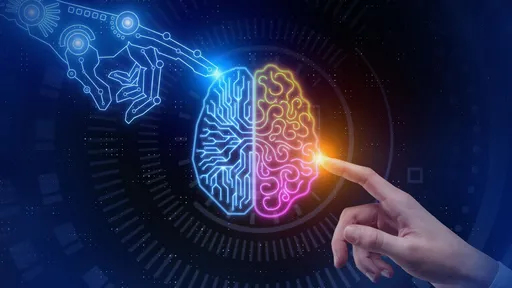

Os bots são criados para facilitar nossa vida. Com eles você podemos realizar ou monitorar várias tarefas sem gastar tanto tempo, como por exemplo responder uma mensagem quando a pessoa não pode fazer isso manualmente ou registrar essas mensagens para um forma de analisa-las posteriomente. (No caso), será criado um bot de monitoramento usando ferramentas de computação em nuvem AWS e linguagem python  

> **Nota:** Este projeto é dedicado a finalização do curso profissão analista de dados da Escola Britânica de artes e tecnologia [(EBAC)](https://ebaconline.com.br/analista-de-dados?utm_source=google&utm_medium=cpc&utm_campaign=course_36_profession-da_google_search_all_conversions_all&utm_content=c_14385805326|adg_127192789358|ad_541002116293|ph_kwd-336945081529|key_analista%20de%20dados|dev_c|pst_|rgnid_1001506|placement_&gclid=Cj0KCQjwmuiTBhDoARIsAPiv6L_pqID-3NUSbive1kdMhwdExSN6wp6xJFlggeDrrKR7PIXRC642u3oaAhTSEALw_wcB)
 






## 0\. Contexto

 - **Arquitetura**

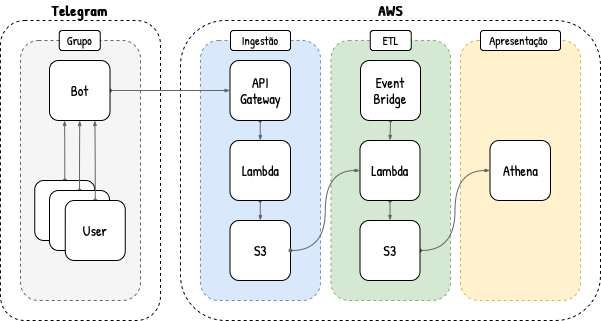

 - **Telegram**

O primeiro passo é criar um bot no Telegram usando o `BotFather`, as mensagens captadas por esse *bot* podem ser acessadas via API. A única informação necessária é o `token` de acesso fornecido pelo `BotFather` na criação do *bot*.

> **Nota:** A documentação completa da API pode ser encontrada neste [link](https://core.telegram.org/bots/api)

* **Token**

In [ ]:
from getpass import getpass

token = getpass()

··········


`Url` base comum a todos os métodos da API.

In [ ]:
import json

base_url = f'https://api.telegram.org/bot{token}'

- **getMe**

O método `getMe` retorna informações sobre o *bot*.

In [ ]:
import requests

response = requests.get(url=f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "id": 5115747309,
    "is_bot": true,
    "first_name": "m43_ebac",
    "username": "pk82_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false
  }
}


 - **getUpdates**

O método `getMe` retorna as mensagens captadas pelo *bot*.

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

## 1\. Ingestão

A etapa de **ingestão** é responsável, (como seu o próprio nome diz), pela ingestão dos dados transacionais em ambientes analíticos. De maneira geral, o dado ingerido é persistido no formato mais próximo do original, ou seja, nenhuma transformação é realizada em seu conteúdo ou estrutura (*schema*). Como exemplo, dados de uma API *web* que segue o formato REST (*representational state transfer*) são entregues, logo, persistidos, no formato JSON.

> Persistir os dados em seu formato original trás muitas vantagens, como a possibilidade de reprocessamento.

Pode ser conduzida de duas formas:

 - **Batch**: blocos de dados são ingeridos em uma frequência bem definida, geralmente na escala de horas ou dias;
 - **Streaming**: dados são ingeridos conforme são produzidos e disponibilizados.

Neste projeto, as mensagens capturadas pelo *bot* podem ser ingeridas através da API *web* de *bots* do **Telegram**, portanto são fornecidos no formato JSON. Como o **Telegram** retem mensagens por apenas 24h em seus servidores, a ingestão via **streaming** é a mais indicada. Para que seja possível esse tipo de **ingestão**, vou utilizar um *webhook* (gancho *web*), ou seja, irei redirecionar as mensagens automaticamente para a minha propria API *web*.

* **Computação em Nuvem**

Sendo assim, o serviço da AWS que fornece uma API *web* para receber os dados redirecionados se chama  `AWS API Gateway` (documentação neste [link](https://docs.aws.amazon.com/pt_br/apigateway/latest/developerguide/welcome.html)). Dentre suas diversas funcionalidades, o `AWS API Gateway` permite o redirecionamento do dado recebido para outros serviços da AWS. Assim posso conecta-lo ao `AWS Lambda`, que por sua vez, irá armazenar o dado em seu formato original (JSON) em um *bucket* do `AWS S3`.

> Sistemas que reagem a eventos são conhecidos como *event-driven*.

Portanto, o passo de ingestão será:

 - Criar um *bucket* no `AWS S3`;
 - Criar uma função no `AWS Lambda`;
 - Criar uma API *web* no `AWS API Gateway`;
 - Configurar o *webhook* da API de *bots* do **Telegram**. 

### **1.1. AWS S3**

Na etapa de **ingestão**, o `AWS S3` tem a função de passivamente armazenar as mensagens captadas pelo *bot* do **Telegram** no seu formato original: JSON. na criação desse *bucket*, como padrão vamos adicionar o sufixo `-raw` ao seu nome para indicar o primeiro estagio de processamento do dado bruto (vamos seguir esse padrão para todos os serviços desta camada).

> **Nota**: um `data lake` é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: *raw* e *enriched* ou *bronze*, *silver* e *gold*.

### **1.2. AWS Lambda**

Na etapa de **ingestão**, o `AWS Lambda` tem a função de ativamente persistir as mensagens captadas pelo *bot* do **Telegram** no *bucket* do `AWS S3` -raw. A função opera da seguinte forma:

 - Recebe a mensagem no parâmetro `event`;
 - Verifica se a mensagem tem origem no grupo do **Telegram** correto;
 - Persiste a mensagem no formato JSON no *bucket* do `AWS S3`;
 - Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de *bots* do **Telegram**.

> **Nota**: No **Telegram**, o *bot* foi restrito a ser adicionados apenas no grupo que estou trabalhando, contudo, ainda é possível iniciar uma conversa em um *chat* privado. Por esse motivo é necessário verificar de onde a id das messagens estão sendo enviadas

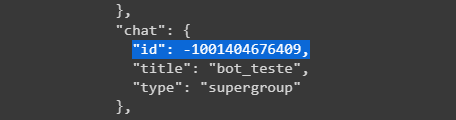

O código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve, 
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID']) # Verificando id 

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')
  
  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

 - **Variáveis de ambiente**

Note que o código exige a configuração de duas variáveis de ambiente: `AWS_S3_BUCKET` com o nome do *bucket* do `AWS S3` e `TELEGRAM_CHAT_ID` com o id do *chat* do grupo do **Telegram**. Para adicionar variáveis de ambiente em uma função do `AWS Lambda`, basta acessar configurações -> variáveis de ambiente no console da função.

> **Nota**: Variáveis de ambiente são excelentes formas de armazenar informações sensíveis.

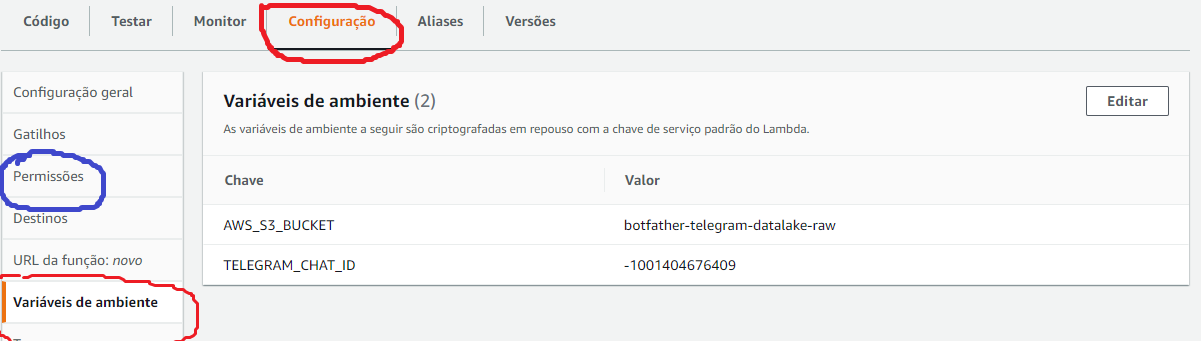

 - **Permissão**

Por fim, adiciono a permissão de escrita no *bucket* do `AWS S3` para a função do `AWS Lambda` no `AWS IAM`.

### **1.3. AWS API Gateway**

Na etapa de **ingestão**, o `AWS API Gateway` tem a função de receber as mensagens captadas pelo *bot* do **Telegram**, enviadas via *webhook*, e iniciar uma função do `AWS Lambda`, passando o conteúdo da mensagem no seu parâmetro *event*. Para tanto sera criada uma API configurada como gatilho da função do `AWS Lambda`:

 - Acesse o serviço e selecione: *Create API* -> *REST API*;
 - Insira um nome, como padrão, um que termine com o sufixo `-api`;
 - Selecione: *Actions* -> *Create Method* -> *POST*;
 - Na tela de *setup*: 
  - Selecione *Integration type* igual a *Lambda Function*;
  - Habilite o *Use Lambda Proxy integration*;
  - Busque pelo nome a função do `AWS Lambda`.


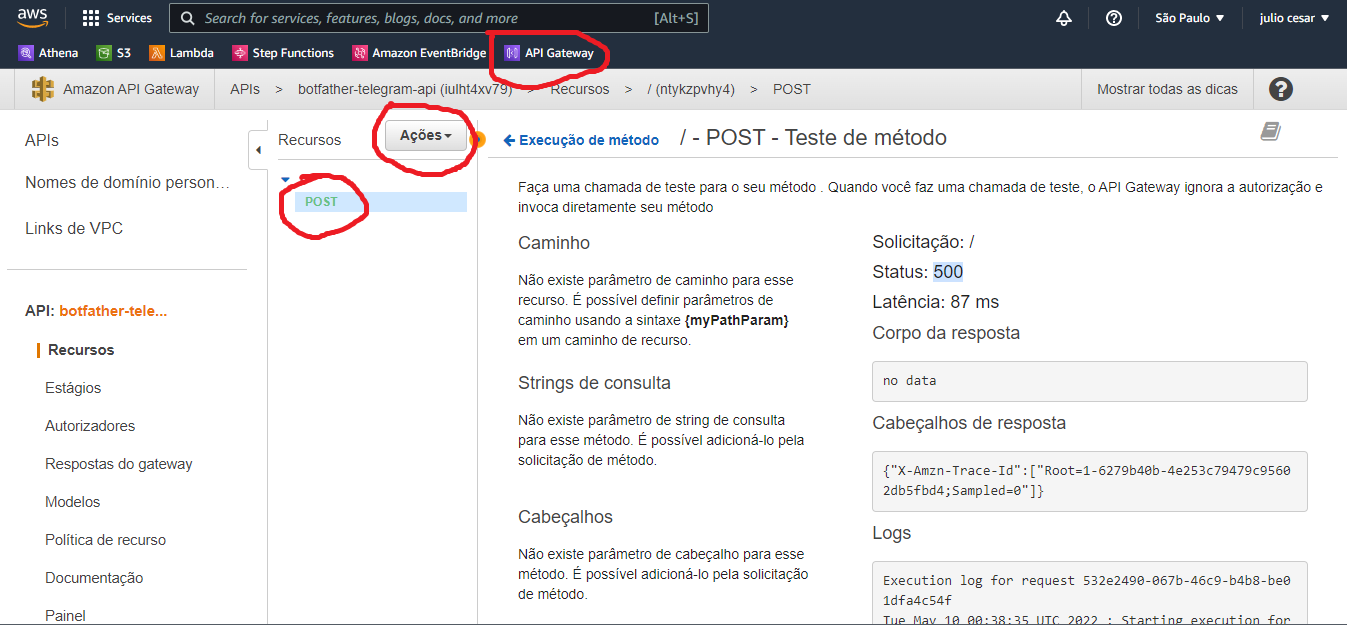

Por fim, sera feito a implantação da API para obter o seu endereço *web*.

 - Selecione: *Actions* -> *Deploy API*;
 - Selecione: *New Stage* para *Deployment stage*;
 - Adicione *dev* como `Stage name`.

Copie o a `url` gerada na variável `aws_api_gateway_url`.

In [ ]:
aws_api_gateway_url = getpass()

# https://iulht4xv79.execute-api.sa-east-1.amazonaws.com/dev

··········


### **1.4. Telegram**

Vamos configurar o *webhook* para redirecionar as mensagens para a `url` do `AWS API Gateway`.

 - **setWebhook**

O método `setWebhook` configura o redirecionamento das mensagens captadas pelo *bot* para o endereço *web* do paramametro `url`.

> **Nota**: os métodos `getUpdates` e `setWebhook` são mutualmente exclusivos, ou seja, enquanto o *webhook* estiver ativo, o método `getUpdates` não funcionará. Para desativar o *webhook*, basta utilizar o método `deleteWebhook`.

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook is already set"
}


 - **getWebhookInfo**

O método `getWebhookInfo` retorna as informações sobre o *webhook* configurado.

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://iulht4xv79.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "max_connections": 40,
    "ip_address": "18.229.221.89"
  }
}


## 2\. ETL

A etapa de **extração, transformação e carregamento** (do inglês *extraction, transformation and load* ou **ETL**) é uma etapa abrangente responsável pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou *raw* de sistemas analíticos. Os processos conduzidos nesta etapa variam bastante de acordo com a área da empresa, do volume/variedade/velocidade do dado consumido, etc. Contudo, em geral, o dado cru ingerido passa por um processo recorrente de *data wrangling* onde o dado é limpo, deduplicado, etc. e persistido com técnicas de particionamento, orientação a coluna e compressão. Por fim, o dado processado está pronto para ser analisado por profissionais de dados.

Nesse projeto, as mensagens de um único dia, persistidas na camada cru, serão compactas em um único arquivo, orientado a coluna e comprimido, que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de *data wrangling*.

Para isso, vou utilizar uma função do `AWS Lambda` como motor de processamento e um *bucket* do `AWS S3` como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, posso configurar uma regra do `AWS Event Bridge` como gatilho diáro da função.

### **2.1. AWS S3** 

Na etapa de **ETL**, o `AWS S3` tem a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato Parquet. Para tanto, basta a criação de um *bucket*. Como padrão, adicionei o sufixo `-enriched` ao seu nome (vou seguir esse padrão para todos os serviços desta camada).

> **Nota**: um `data lake` é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: *raw* e *enriched* ou *bronze*, *silver* e *gold*.

### **2.2. AWS Lambda** 

Na etapa de **ETL**, o `AWS Lambda` tem a função de ativamente processar as mensagens captadas pelo *bot* do **Telegram**, persistidas na camada cru no *bucket* do `AWS S3`, e persisti-las na camada enriquecida, também em um *bucket* do `AWS S3`. Logo, a função opera da seguinte forma:

 - Lista todos os arquivos JSON de uma única participação da camada crua de um *bucket* do `AWS S3`;
 - Para cada arquivo listado:
  - Faz o *download* do arquivo e carrega o conteúdo da mensagem;
  - Executa uma função de *data wrangling*;
  - Cria uma tabela do PyArrow e a contatena com as demais.
 - Persiste a tabela no formato Parquet na camada enriquecida em um *bucket* do `AWS S3`.

> **Nota**: O fato de utilizar duas camadas de armazenamento e processamento, permite que possamos reprocessar os dados crus de diversas maneiras, quantas vezes forem preciso.

O código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False

O código da função de *data wrangling*:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

 - **Variáveis de ambiente**

Note que o código exige a configuração de duas variáveis de ambiente: `AWS_S3_BUCKET` e `AWS_S3_ENRICHED` com os nomes dos *bucket* do `AWS S3` da camada cru e enriquecida, respectivamente. Para adicionar variáveis de ambiente em uma função do `AWS Lambda`, basta acessar configurações -> variáveis de ambiente no console da função e repetir o mesmo processo que foi feito no datalake-raw.

 - **Permissão**

Permissão de escrita nos *buckets* do `AWS S3` para a função do `AWS Lambda` no `AWS IAM`.

 - **Recursos**

O *timeout* padrão de funcões do `AWS Lambda` é de 3 segundos. Para a função, é necessario aumentar o tempo para 5 minutos, principalmente para lidar com o IO (*input/output*) de arquivos do `AWS S3`. apesar de que esse tempo não será inteiramente necessario

 - **Camadas**

Por fim, note que o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do `AWS Lambda` possui poucos pacotes externos instalado, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou *layers*, onde podemos fazer o *upload* dos pacotes Python direto na plataforma ou através de um *bucket* do `AWS S3`. Então vou seguir com a última opção, onde irei:

 - Criar um *bucket* no `AWS S3`;
 - Fazer o *upload* do código do pacote Python do PyArrow (*download* neste [link](https://github.com/awslabs/aws-data-wrangler/releases));
 - Criar *layer* e conectar na função.

### **2.3. AWS Event Bridge** 

Na etapa de **ETL**, o `AWS Event Bridge` tem a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler*.

> **Nota**: A função processa as mensagens do dia anterior (D-1).

## 3\. Apresentação

A etapa de **apresentação** é reponsável por entregar o dado para os usuários (analistas, cientistas, etc.) e sistemas (dashboards, motores de consultas, etc.), idealmente através de uma interface de fácil uso, como o SQL, logo, essa é a única etapa que a maioria dos usuários terá acesso. Além disso, é importante que as ferramentas da etapa entregem dados armazenados em camadas refinadas, pois assim as consultas são mais baratas e o dados mais consistentes.

### **3.1. AWS Athena** 

Na etapa de **apresentação**, o `AWS Athena` tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint, 
  `user_id` bigint, 
  `user_is_bot` boolean, 
  `user_first_name` string, 
  `chat_id` bigint, 
  `chat_type` string, 
  `text` string, 
  `date` bigint)
PARTITIONED BY ( 
  `context_date` date)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'
```

Por fim, adicionei as partições disponíveis.

> **Importante**: Toda vez que uma nova partição é adicionada ao repositório de dados, é necessário informar o `AWS Athena` para que a ela esteja disponível via SQL. Para isso, uso o comando SQL `MSCK REPAIR TABLE <nome-tabela>` para todas as partições ou `ALTER TABLE <nome-tabela> ADD PARTITION <coluna-partição> = <valor-partição>` para uma única partição, documentação está neste [link](https://docs.aws.amazon.com/athena/latest/ug/alter-table-add-partition.html)).

```sql
MSCK REPAIR TABLE `telegram`;
```

Consulta das 10 primeiras linhas, vamos observar o resultado.

```sql
SELECT * FROM "telegram" LIMIT 10;
```

* Donwload da query resultado, oberserve que so tenho uma mensagem hello world. enviada no grupo para teste

In [ ]:
import pandas as pd

data = pd.read_csv('dataset-mgs.csv', sep=',', encoding='utf-8')

In [ ]:
data.head()

,message_id,user_id,user_is_bot,user_first_name,chat_id,chat_type,text,date,context_date
0,10,1226716327,False,Julio.pk,-1001404676409,supergroup,hello! world,1652190593,2022-05-10


### **3.2. Analytics** 

Com o dado disponível, usuário podem executar as mais variadas consultas analíticas. Seguem alguns exemplos:

- Quantidade de mensagens por dia.

```sql
SELECT 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY context_date 
ORDER BY context_date DESC
```

- Quantidade de mensagens por usuário por dia.

```sql
SELECT 
  user_id, 
  user_first_name, 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY 
  user_id, 
  user_first_name, 
  context_date 
ORDER BY context_date DESC
```

- Média do tamanho das mensagens por usuário por dia.

```sql
SELECT 
  user_id, 
  user_first_name, 
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length" 
FROM "telegram" 
GROUP BY 
  user_id, 
  user_first_name, 
  context_date 
ORDER BY context_date DESC
```

- Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH 
parsed_date_cte AS (
    SELECT 
        *, 
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram" 
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount" 
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```